<a href="https://colab.research.google.com/github/CompOmics/lsabd-machine-learning-tutorials/blob/main/notebooks/2-dimensionality-reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set the style for our visualizations
sns.set_style("whitegrid")
sns.set_palette("deep")

%matplotlib inline

In [2]:
# Some utility functions for plotting
def plot_eigenvectors(dataset, w, v):
    plt.plot(dataset["x1"], dataset["x2"], "bo", markersize=5)
    plt.arrow(0, 0, 10 * v[0, 0], 10 * v[1, 0], color="r", linewidth=2, head_width=1, head_length=1)
    plt.arrow( 0, 0, 10 * v[0, 1], 10 * v[1, 1], color="r", linewidth=2, head_width=1, head_length=1)
    plt.text( 12 * v[0, 0], 10 * v[1, 0], r"PC1, $\vec{v_1}$ =  %.2f $\vec{x_1}$ + %.2f $\vec{x_2}$" % (v[0, 0], v[1, 0]))
    plt.text( 26 * v[0, 1], 8 * v[1, 1], r"PC2, $\vec{v_2}$ =  %.2f $\vec{x_&}$ + %.2f $\vec{x_2}$" % (v[0, 1], v[1, 1]))


def plot_scatter_annotated(dataset, labels):
    X = dataset.values
    plt.figure(figsize=(12, 12))
    plt.scatter(X[:, 0], X[:, 1], s=100)
    for i, (x, y) in enumerate(zip(X[:, 0], X[:, 1])):
        plt.annotate(
            labels[i],
            xy=(x, y),
            xytext=(-20, 20),
            textcoords="offset points",
            ha="right",
            va="bottom",
            bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.5),
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0"),
        )

# 2. Dimensionality reduction


## 2.1 Theory behind PCA

Dimensionality reduction is often useful for visualizing data and improving model performance by reducing overfitting and computational requirements. By removing noisy or correlated features, we can simplify the data while preserving as much relevant information as possible. When reducing the number of features to fewer than four, the data can often be visualized effectively, for example, in a scatterplot.

In this context, we will first focus on **Principal Component Analysis (PCA)**, a popular **feature extraction** technique. PCA transforms the original data into a new set of features, known as principal components (PCs), which are orthogonal to each other and point in the direction of maximum variance.


PCA decomposes a data set in its principal components (PC) through a **linear** transformation. PC's (also called eigenvectors) are **orthogonal** to each other and point in the direction of **largest variance**. So what does this mean? Let's say we have a data set with two features and we want to reduce this data to one feature.

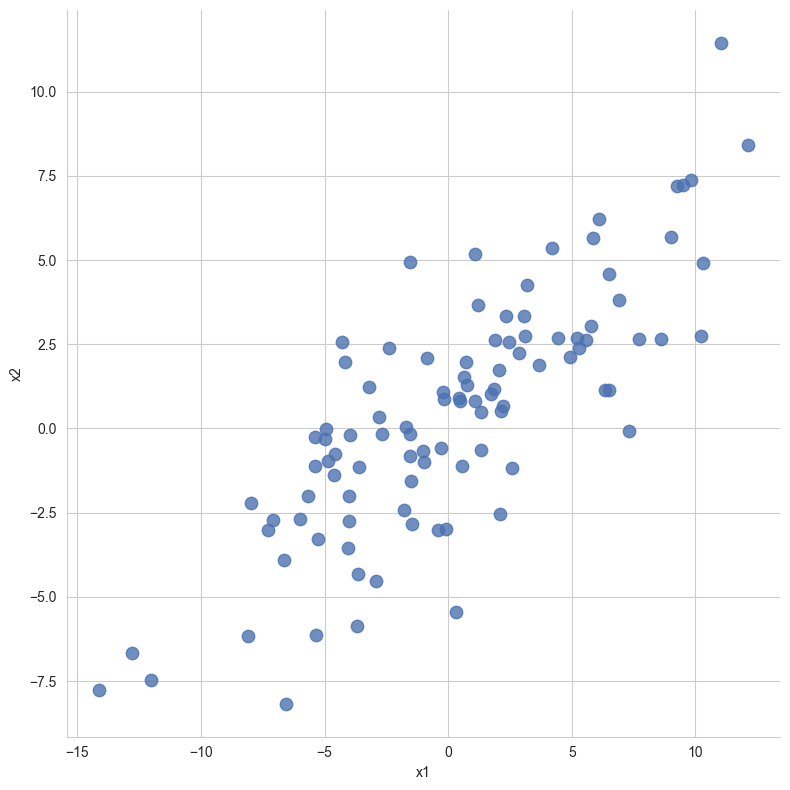

In [3]:
dataset = pd.read_csv('https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_data/master/notebooks/8_dimensionality_reduction/pca.csv')
sns.lmplot(x="x1", y="x2", data=dataset, fit_reg=False, height=8, scatter_kws={"s": 80})
plt.show()

To apply PCA the data needs to be **centered** first. In this case it was centered already. PCA will search for the direction that preserves the most of the original variance. This is vector PC1 in the plot below.

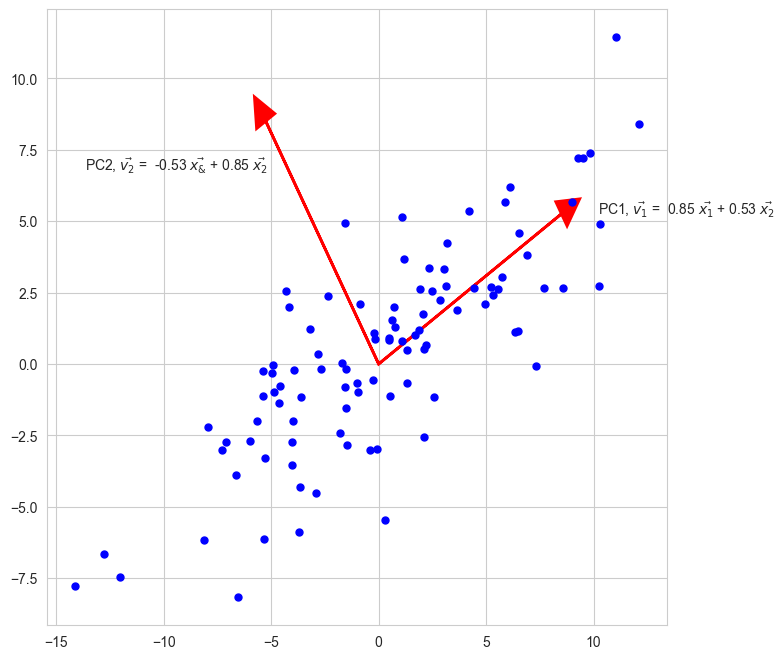

In [4]:
w,v=np.linalg.eig(np.cov(dataset.values.T)) #finds the eigenvalues and principle components (eigenvectors)

plt.figure(figsize=(8,8))
plot_eigenvectors(dataset,w,v)
plt.show()

The second principal component (PC2) is orthogonal to the first (PC1). Together, PC1 and PC2 define a new space where PC1 captures most of the variance in the data. In general, for an $n$-dimensional dataset, PCA computes $n$ principal components, where each component captures the maximum variance while being orthogonal to the previous ones.

Each $i$-th principal component has an **eigenvalue** $w_i$, which represents the amount of variance explained by that component.


In [5]:
print("Eigenvalue for PC1 (w_0): {:.2f}".format(w[0]))
print("Eigenvalue for PC2 (w_1): {:.2f}".format(w[1]))

Eigenvalue for PC1 (w_0): 38.81
Eigenvalue for PC2 (w_1): 3.48


The amount of variance explained by each PC $i$ is given by

$$\frac{w_i}{\sum_j w_j},$$

where $j$ ranges over all PCs.

In [6]:
var_explained=100*w/sum(w)
print("Variance explained by PC1: {}".format(var_explained[0]))
print("Variance explained by PC2: {}".format(var_explained[1]))

Variance explained by PC1: 91.77589516379086
Variance explained by PC2: 8.22410483620912


The first principal component (PC1) explains most of the variance in the original dataset. To reduce the number of dimensions, we can remove PC2 and project all data points onto PC1, which preserves 91.78% of the variance. In contrast, projecting onto PC2 alone preserves only 8.22%. Thus, to visualize an $n$-dimensional dataset, we can project it onto the top two or three principal components.

For example, if we remove PC2 and project the data onto PC1, we can compute the new feature values from the original features $x_1$ and $x_2$ as:

$$\vec{v_1} =  0.85 \vec{x_1} + 0.53 \vec{x_2}.$$

Here, we replace the original features $x_1$ and $x_2$ with the new feature $v_1$, which can then be plotted as a histogram.


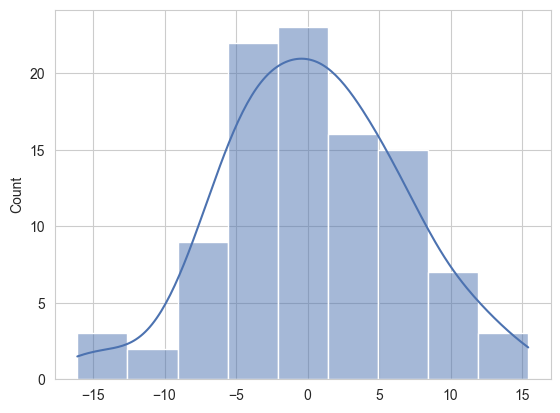

In [7]:
sns.histplot(v[0,0]*dataset['x1']+v[1,0]*dataset['x2'], kde=True)
plt.show()

The variance of this distribution is thus 38.81. To show how PCA is applied using the PCA module in scikit-learn we first create an artificial data set with 100 samples in two classes. There are 100 features of which 10 are informative:

In [8]:
import sklearn.datasets as datasets

(dataset_big, targets) = datasets.make_classification(
    n_samples=100,
    n_features=100,
    n_classes=2,
    n_informative=10,
    n_redundant=0,
    n_repeated=0,
    class_sep=2,
    n_clusters_per_class=1,
    random_state=2,
)

Remember that this dataset is 100-dimensional, which makes it impossible to visualize directly.

Now we apply PCA and keep only the two top principle components. The data set is projected (or transformed) onto these two new dimensions and plotted:

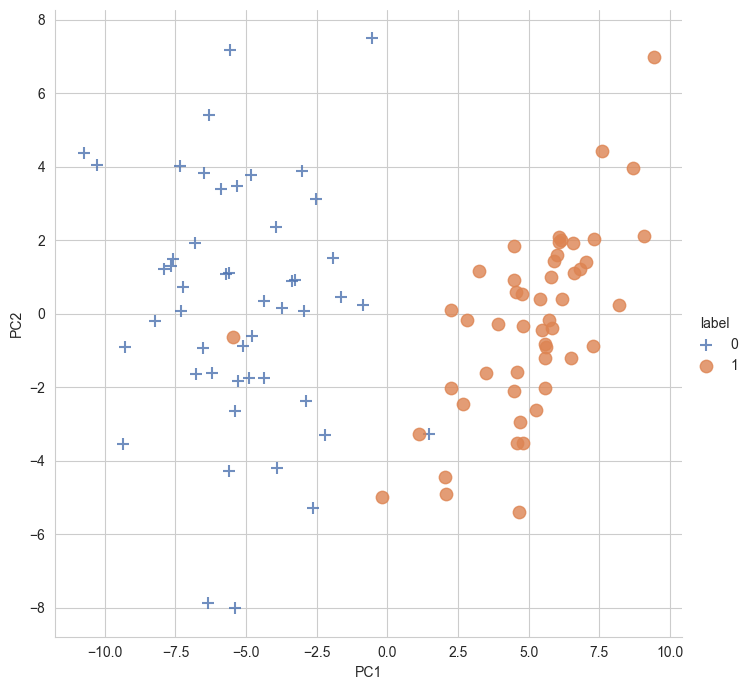

In [9]:
from sklearn.decomposition import PCA

pca_model = PCA(n_components=2)
dataset_big_projected = pd.DataFrame(
    pca_model.fit(dataset_big).transform(dataset_big), columns=["PC1", "PC2"]
)
dataset_big_projected["label"] = targets

sns.lmplot(
    x="PC1",
    y="PC2",
    data=dataset_big_projected,
    hue="label",
    markers=["+", "o"],
    fit_reg=False,
    height=7,
    scatter_kws={"s": 80},
)
plt.show()

The plots reveals the two classes (remember these were not known to the PCA algorithm) and also reveals possible outliers in both classes. We can look at the explained variance for each PC:

In [10]:
print("Variance explained by PC1: {}".format(pca_model.explained_variance_ratio_[0]))
print("Variance explained by PC2: {}".format(pca_model.explained_variance_ratio_[1]))

Variance explained by PC1: 0.21411594016511135
Variance explained by PC2: 0.056570215383521257


We observe how PC1 and PC2 together only explain about 27% of the original variance while still providing useful structural information about the 100-dimensional data set.

## 2.2 Applying PCA, t-SNE, and UMAP to a real dataset

In [11]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import umap
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE

## Dataset Description

**Study:** *Feminizing gender-affirming hormone therapy remodels the plasma proteome*

**Source:** 
- Article: [Nature Medicine (2025)](https://www.nature.com/articles/s41591-025-04023-9)
- Data: [PRIDE Archive Project PAD000016](https://www.ebi.ac.uk/pride/archive/projects/PAD000016)

**Abstract:**

Sex differences manifest in various traits, as well as in the risk of cardiovascular, metabolic and immunological conditions. Despite the clear physical changes induced by gender-affirming hormone therapy (GAHT), little is known about how it affects underlying physiological and biochemical processes. Here we examined plasma proteome changes over 6 months of feminizing GAHT in 40 transgender individuals treated with estradiol plus one of two antiandrogens: cyproterone acetate or spironolactone. Testosterone levels dropped markedly in the cyproterone group, but less so in those receiving spironolactone. Among 5,279 total proteins measured, feminizing GAHT changed the levels of 245 and 91, in the cyproterone and spironolactone groups, respectively, with most (>95%) showing a decrease. Proteins associated with male spermatogenesis showed a marked decrease in the cyproterone group, attributable specifically to loss of testosterone. Changes in body fat percentage and breast volume following GAHT were also reflected in the plasma proteome, including an increase in leptin expression. We show that feminizing GAHT remodels the proteome toward a cis-female profile, altering 36 (cyproterone) and 22 (spironolactone) of the top 100 sex-associated proteins in UK Biobank adult data. Moreover, 43% of cyproterone-affected proteins overlapped with those altered by menopausal hormone therapy in cis women, showing the same directional changes, with notable exceptions including CXCL13 and NOS3. Feminizing GAHT skewed the protein profile toward that linked to asthma and autoimmunity, while GAHT with cyproterone specifically skewed it away from an atherosclerosis-associated profile, suggesting a protective effect. These results reveal that feminizing GAHT reshapes the plasma proteome in a hormone-dependent manner, with implications for reproductive capacity, immune regulation and long-term health outcomes.

**Dataset Details:**

- **Samples:** 113 plasma samples from transgender individuals undergoing feminizing GAHT, cis-female controls, cis-male controls, and pregnant individuals
- **Features:** 5,440 proteins measured using proximity extension assay (PEA) technology
- **Phenotype Groups:**
  - SPIRO_GAHT (spironolactone + estradiol): baseline and 6-month timepoints
  - CPA_GAHT (cyproterone acetate + estradiol): baseline and 6-month timepoints
  - Control groups: cis-female and cis-male at baseline and follow-up timepoints
  - Pregnancy: trimester 1 and trimester 3 samples
- **Data Format:** Protein expression values are reported as PCNormalizedNPX values

**Analysis Goal:**

In this notebook, we apply three dimensionality reduction techniques—**PCA** (Principal Component Analysis), **t-SNE** (t-distributed Stochastic Neighbor Embedding), and **UMAP** (Uniform Manifold Approximation and Projection)—to visualize how the plasma proteome differs across phenotype groups and to identify key proteins driving these differences.

In [12]:
# Load the datasets
data_file = "https://raw.githubusercontent.com/CompOmics/lsabd-machine-learning-tutorials/refs/heads/main/data/PAD000016_data.csv"
metadata_file = "https://raw.githubusercontent.com/CompOmics/lsabd-machine-learning-tutorials/refs/heads/main/data/GAHT_pregnancy_metadata_SDRF.tsv"

# Read the CSV and TSV files
data_df = pd.read_csv(data_file)
metadata_df = pd.read_csv(metadata_file, sep="\t")

# Extracting the phenotype label column `actor value[phenotype]` from the metadata
phenotype_labels = metadata_df["factor value[phenotype]"]

# Pivoting the data into wide format using the `pivot_table` method
# Columns needed are `SampleID`, `Assay`, and ` PCNormalizedNPX`
# Use `aggfunc="first"` to handle duplicates
data_wide = data_df.pivot_table(
    index="SampleID", columns="Assay", values="PCNormalizedNPX", aggfunc="first"
)

# Filling missing values with the mean of each column (`data_wide.mean()`) using the `fillna` method
data_wide_filled_missing_values = data_wide.fillna(data_wide.mean())

# Align phenotype labels with the sample_subset index
# Match the metadata sample IDs with the data sample IDs
phenotype_labels_aligned = metadata_df.set_index("source name")["factor value[phenotype]"].reindex(
    data_wide_filled_missing_values.index, fill_value="Unknown"
)

*Question 1: Do we need the labels for dimensionality reduction?*

*Answer 1: No, dimensionality reduction techniques are unsupervised methods that do not require labels. However, labels can be useful for interpreting the results after the dimensionality reduction has been performed.*

*Question 2: Here we do not normalize the data, is normalization necessary for dimensionality reduction? If yes, why? If yes, what kind of normalization?*

*Answer 2: Normalization or standardization is generally required before PCA, t-SNE, and UMAP to ensure that features with different scales or variances do not dominate the analysis. This ensures that each feature contributes equally to the dimensionality reduction process, improving the accuracy of the results.*

*Here, no normalization is applied because the PCNormalizedNPX values are already pre-processed and normalized protein expression values provided in the dataset.*

Next we will fit the models to perform the dimensionality reduction. You can always look at the documentation to see how the models should be fitted [scikit-learn](https://scikit-learn.org/stable/) and [UMAP](https://umap-learn.readthedocs.io/en/latest/).

Because we are now using unsupervized learning methods, we can safely use the `fit_transform` method to fit and transform the data in one step.

In [13]:
# Perform PCA
pca_model = PCA(n_components=2)
pca_result = pca_model.fit_transform(data_wide_filled_missing_values)

# Perform t-SNE with parallelization and adjusted perplexity for performance
tsne_model = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne_model.fit_transform(data_wide_filled_missing_values)

# Perform UMAP (ensure umap-learn is installed)
umap_model = umap.UMAP(n_components=2, n_jobs=1, random_state=42)
umap_result = umap_model.fit_transform(data_wide_filled_missing_values)

Next we plot the results from the different dimensionality reduction models.

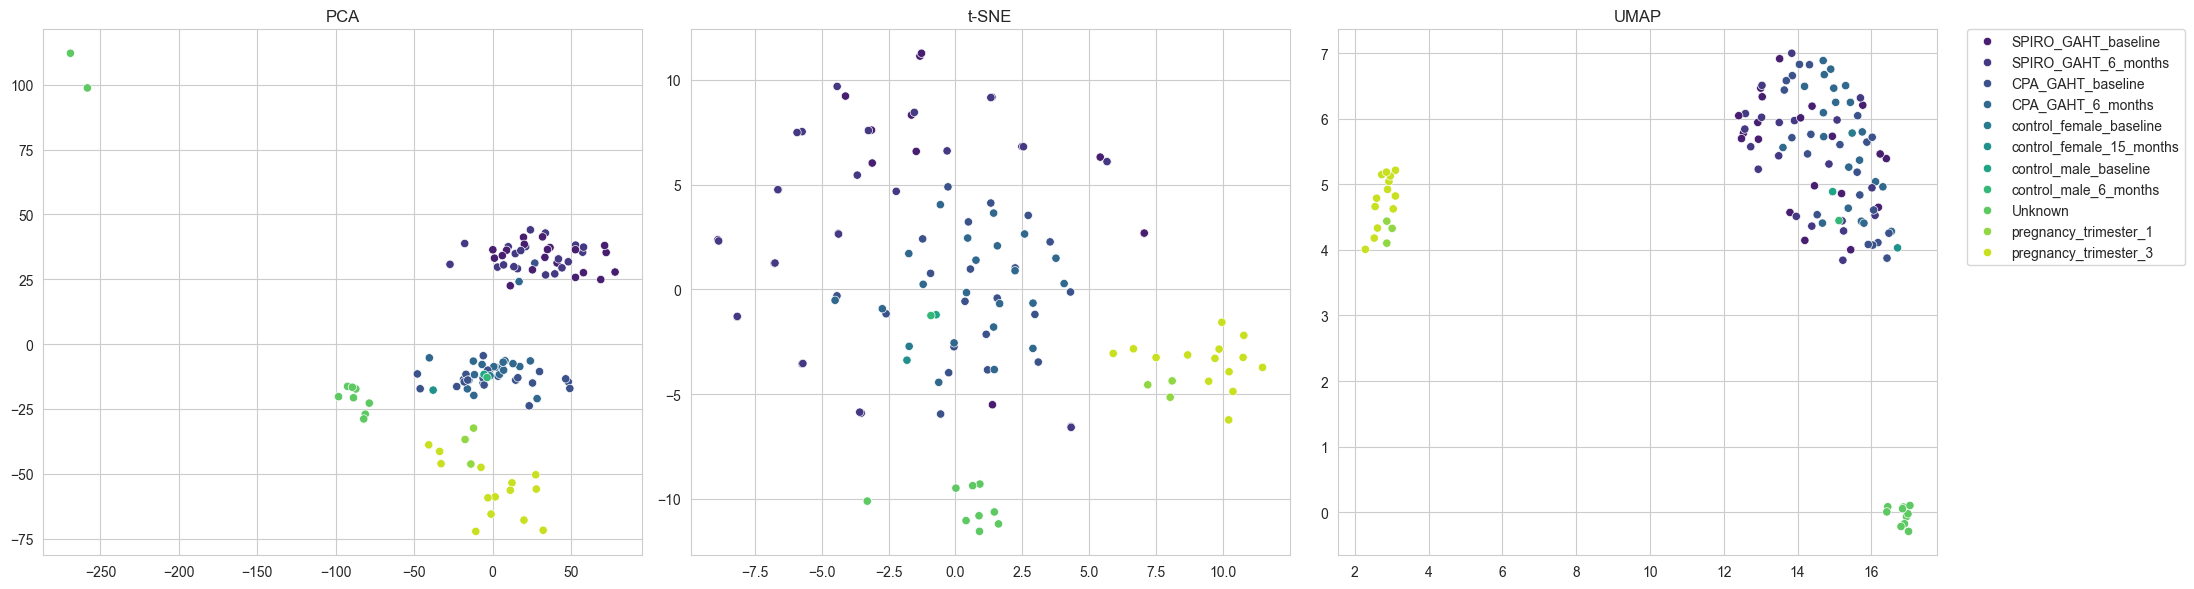

In [14]:
# Plotting PCA, t-SNE, and UMAP results
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# PCA plot
sns.scatterplot(
    x=pca_result[:, 0],
    y=pca_result[:, 1],
    hue=phenotype_labels_aligned,
    ax=axes[0],
    palette="viridis",
    legend=False,
)
axes[0].set_title("PCA")

# t-SNE plot
sns.scatterplot(
    x=tsne_result[:, 0],
    y=tsne_result[:, 1],
    hue=phenotype_labels_aligned,
    ax=axes[1],
    palette="viridis",
    legend=False,
)
axes[1].set_title("t-SNE")

# UMAP plot
sns.scatterplot(
    x=umap_result[:, 0],
    y=umap_result[:, 1],
    hue=phenotype_labels_aligned,
    ax=axes[2],
    palette="viridis",
)
axes[2].set_title("UMAP")

# Move legend outside the plot area to the right
axes[2].legend(
    bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0, frameon=True
)

plt.tight_layout()
plt.show()

*Question 3: What are the differences between the different algorithms? Are the differences you see expected for PCA/t-SNE/UMAP?*

*Answer 3: Yes, the differences are expected. While t-SNE captures local structures well, UMAP balances local and global structures, and PCA completely focuses on preserving global variance. This dataset seems to contain more global structures, leading to clearer separations in PCA and UMAP compared to t-SNE.*


*Question 4: What could this visualization be useful for?*

*Answer 4: These visualizations can help identify clusters or patterns in the data, such as distinct phenotype groups or outliers. They can also provide insights into the underlying biological processes and guide further analyses. Specifically, the UMAP and t-SNE plots show how the SPIRO and CPA treatments affect the plasma proteome somewhat similarly.*

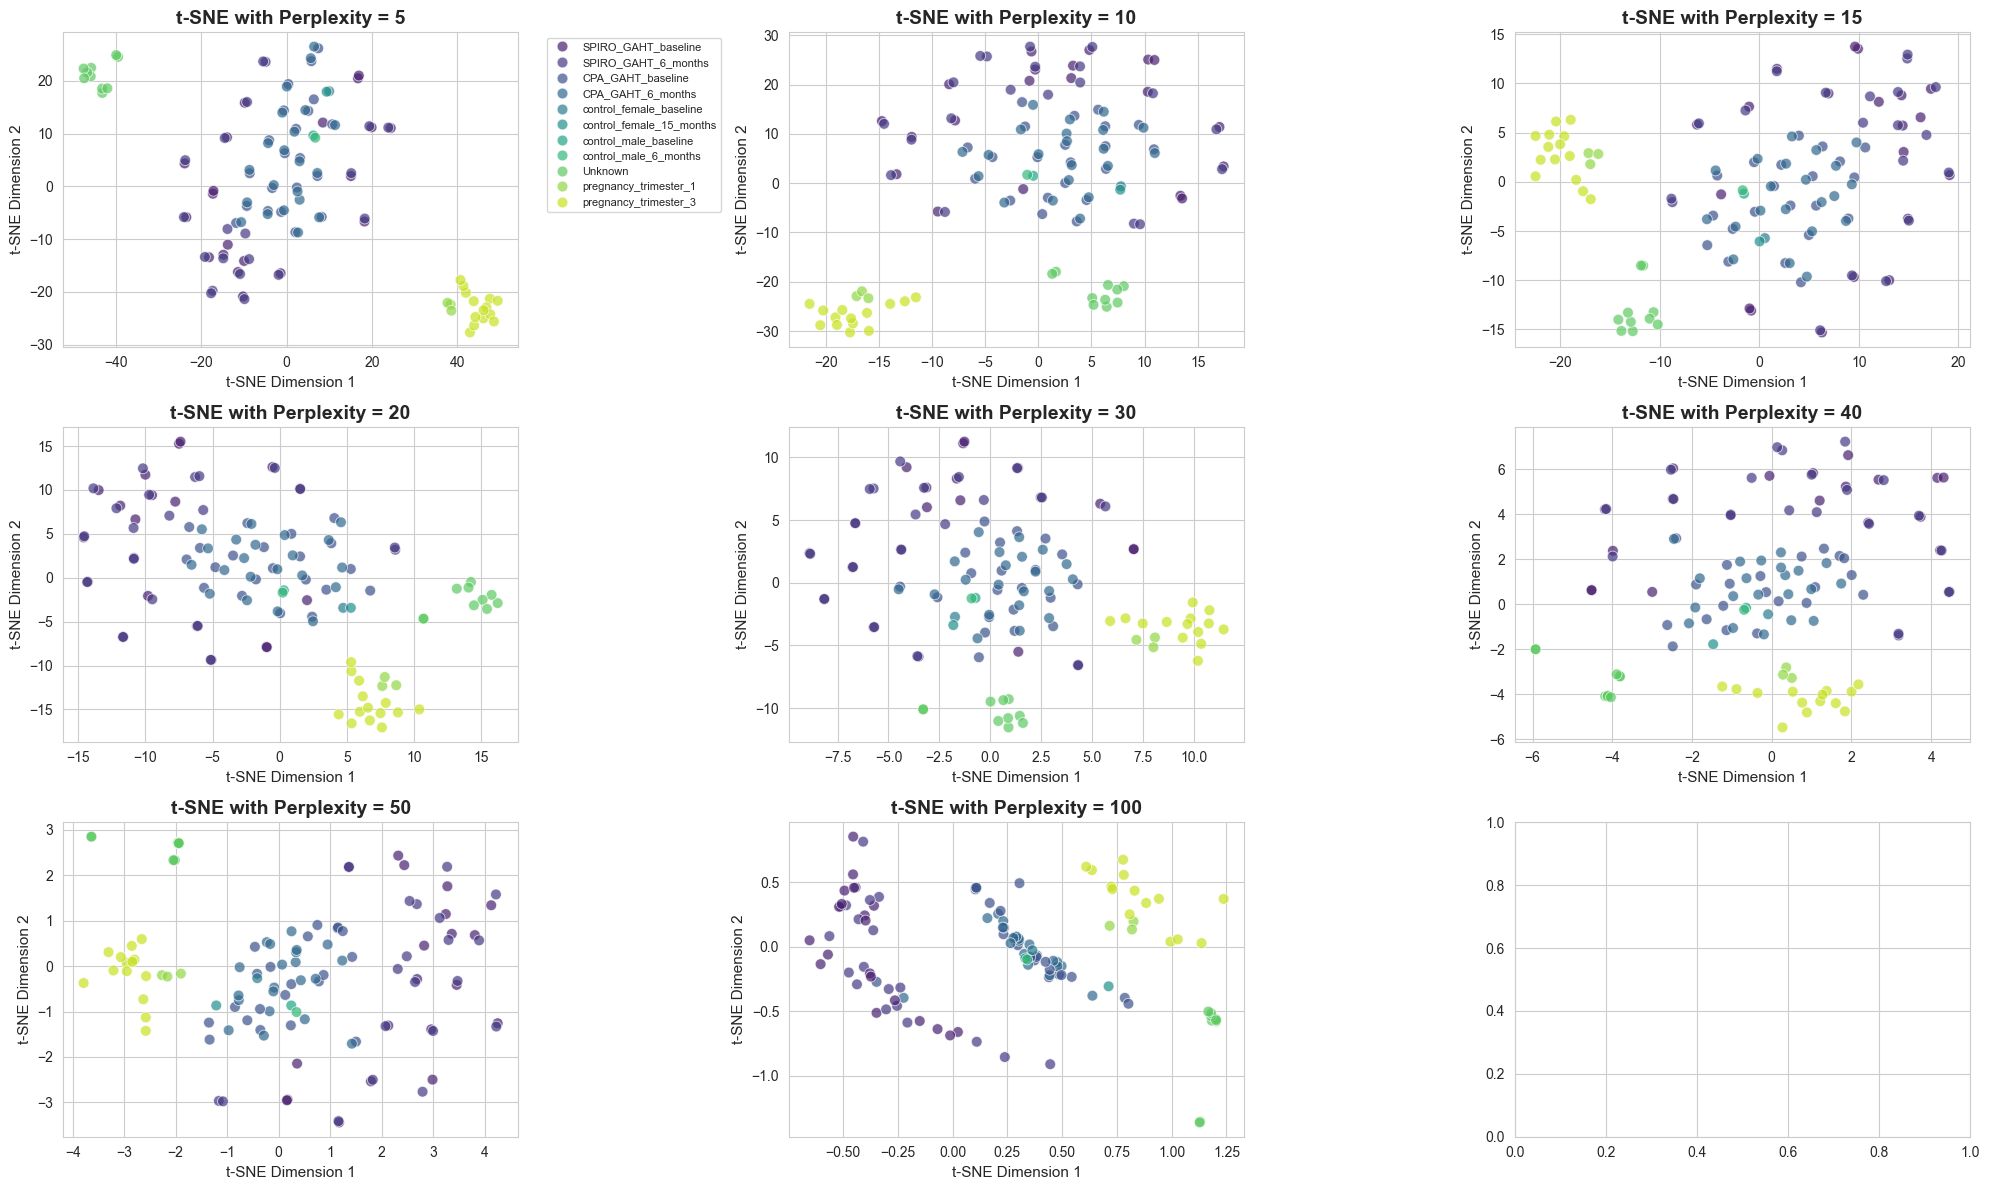

In [15]:
# Test different perplexity values
perplexity_values = [5, 10, 15, 20, 30, 40, 50, 100]

fig, axes = plt.subplots(math.ceil(len(perplexity_values) / 3), 3, figsize=(20, 12))
axes = axes.flatten()

for idx, perp in enumerate(perplexity_values):
    # Run t-SNE with different perplexity
    tsne_temp = TSNE(n_components=2, perplexity=perp, random_state=42, n_jobs=-1)
    tsne_temp_result = tsne_temp.fit_transform(data_wide_filled_missing_values)

    # Scatter plot of t-SNE
    sns.scatterplot(
        x=tsne_temp_result[:, 0],
        y=tsne_temp_result[:, 1],
        hue=phenotype_labels_aligned,
        ax=axes[idx],
        palette="viridis",
        legend=(idx == 0),
        s=60,
        alpha=0.7,
    )

    axes[idx].set_title(
        f"t-SNE with Perplexity = {perp}", fontsize=14, fontweight="bold"
    )
    axes[idx].set_xlabel("t-SNE Dimension 1", fontsize=11)
    axes[idx].set_ylabel("t-SNE Dimension 2", fontsize=11)

    if idx == 0:
        axes[idx].legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)

plt.tight_layout()
plt.show()

*Question 5:  How do different perplexity values have an effect on the dimensionality reduction?*

*Answer 5: The perplexity parameter in t-SNE influences the balance between local and global aspects of the data. Lower perplexity values focus more on local structures, potentially leading to more fragmented clusters, while higher values capture broader global structures, which can result in more cohesive clusters. The choice of perplexity can significantly affect the resulting visualization, so it's important to experiment with different values to find the most informative representation for the specific dataset.*

*Question 6:  How do you select an appropriate perplexity value?*

*Answer 6: Finding a good perplexity value often involves trial and error, as well as some previous knowledge about the dataset. A common approach is to try a range of sensible values (e.g., 5 to 50) and evaluate the resulting visualizations for cluster separation or general interpretability. Make sure not to set the perplexity higher than the number of samples divided by 3, as this can lead to poor results.*

## Feature Importances and Interpretation

For PCA, we can examine the **loadings** (also called components or feature weights) which tell us how much each original feature (protein) contributes to each principal component. Features with large absolute loadings have the most influence on that PC and can be considered important features in the dataset.

In [16]:
# PCA Feature Importances (Loadings)
# Get the loadings for PC1 and PC2
loadings = pd.DataFrame(
    pca_model.components_.T,
    columns=['PC1', 'PC2'],
    index=data_wide_filled_missing_values.columns
)

# Calculate the absolute importance (magnitude of loading)
loadings['PC1_abs'] = np.abs(loadings['PC1'])
loadings['PC2_abs'] = np.abs(loadings['PC2'])

# Get top 15 features for each PC
top_pc1 = loadings.nlargest(15, 'PC1_abs')[['PC1']].sort_values('PC1')
top_pc2 = loadings.nlargest(15, 'PC2_abs')[['PC2']].sort_values('PC2')

expl_variance = pca_model.explained_variance_ratio_
print("Variance explained by PC1: {:.2f}%".format(expl_variance[0] * 100))
print("Variance explained by PC2: {:.2f}%".format(expl_variance[1] * 100))
print("Total variance explained: {:.2f}%".format(sum(expl_variance) * 100))

Variance explained by PC1: 20.31%
Variance explained by PC2: 9.15%
Total variance explained: 29.47%


*Question 7: Is the variance explained by PC1 large when considering the number of features? Is there a steep drop-off in variance explained? Is this expected?*

*Answer 7: The variance explained by PC1 is relatively high when considering the large number of features (proteins) in the dataset. The steep drop-off in variance explained after PC1 is expected, as PCA often captures most of the variance in the first few components, especially in high-dimensional datasets where many features may be correlated or contain noise.*

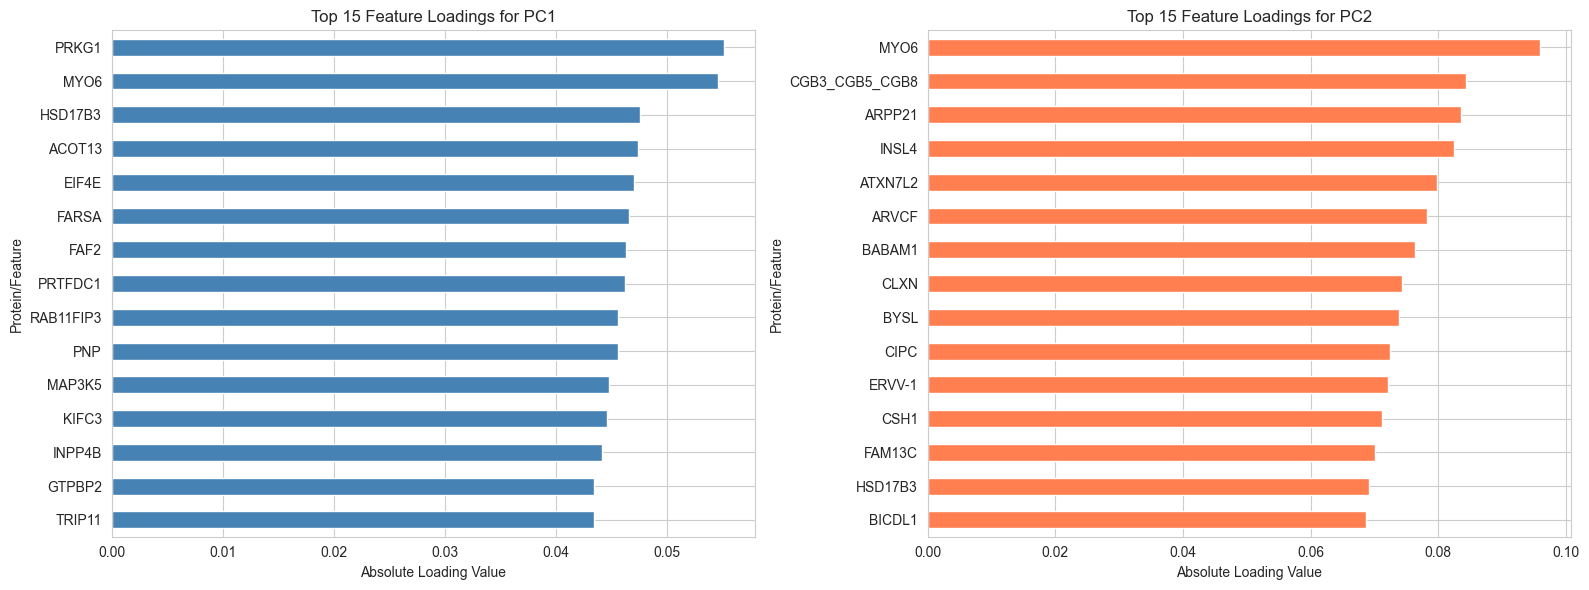

In [17]:
# Visualize top feature loadings for PC1 and PC2
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PC1 loadings
top_pc1.abs().sort_values(by="PC1").plot(
    kind="barh", ax=axes[0], color="steelblue", legend=False
)
axes[0].set_title("Top 15 Feature Loadings for PC1")
axes[0].set_xlabel("Absolute Loading Value")
axes[0].set_ylabel("Protein/Feature")
axes[0].axvline(x=0, color="black", linestyle="-", linewidth=0.5)

# PC2 loadings
data = top_pc2.abs().sort_values(by="PC2")
data.plot(
    kind="barh", ax=axes[1], color="coral", legend=False
)
axes[1].set_title("Top 15 Feature Loadings for PC2")
axes[1].set_xlabel("Absolute Loading Value")
axes[1].set_ylabel("Protein/Feature")
axes[1].axvline(x=0, color="black", linestyle="-", linewidth=0.5)

plt.tight_layout()
plt.show()

*Question 8: What are the top 5 most important proteins for PC1 and PC2, respectively?*

*Answer 8: The ones with the highest absolute loadings in the respective principal components.*

*Question 9: Can the loadings between different principal components overlap? What does it indicate if a protein has a high loading for the first couple of components? How can we account for this spread of loadings?*

*Answer 9: Yes, loadings between different principal components can overlap, meaning that some proteins may have high loadings in multiple PCs.*

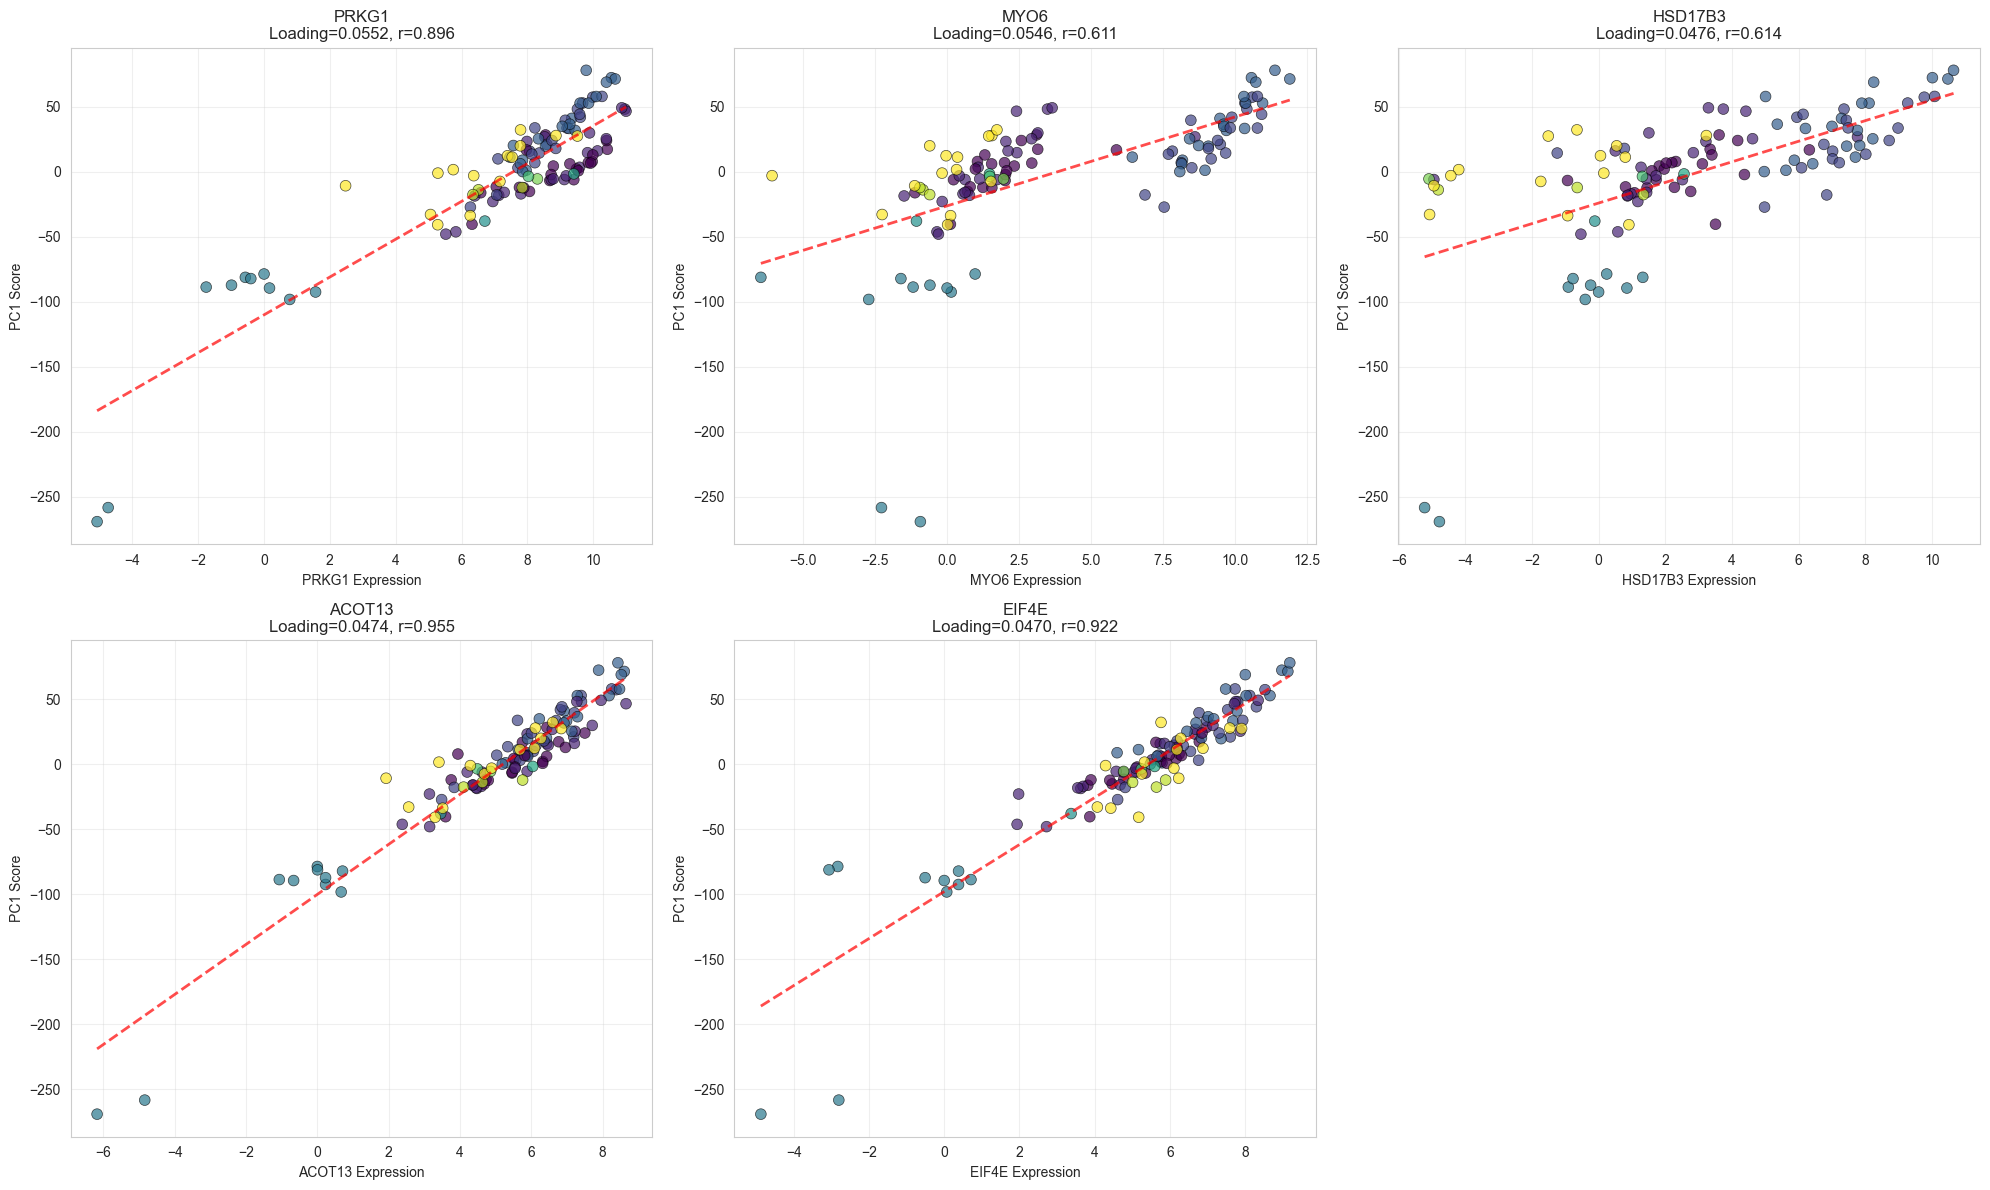

In [18]:
# Get top 5 features for PC1
top_5_pc1_features = loadings.nlargest(5, "PC1_abs").index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, feature in enumerate(top_5_pc1_features):
    ax = axes[idx]

    # Scatter plot: Feature vs PC1
    scatter = ax.scatter(
        data_wide_filled_missing_values[feature],
        pca_result[:, 0],
        c=pd.Categorical(phenotype_labels_aligned).codes,
        cmap="viridis",
        s=60,
        alpha=0.7,
        edgecolors="black",
        linewidth=0.5,
    )

    # Calculate correlation
    corr = np.corrcoef(data_wide_filled_missing_values[feature], pca_result[:, 0])[0, 1]

    # Add regression line using sklearn
    X = data_wide_filled_missing_values[feature].values.reshape(-1, 1)
    y = pca_result[:, 0]
    reg = LinearRegression().fit(X, y)

    line_x = np.array(
        [
            data_wide_filled_missing_values[feature].min(),
            data_wide_filled_missing_values[feature].max(),
        ]
    ).reshape(-1, 1)
    line_y = reg.predict(line_x)
    ax.plot(line_x, line_y, "r--", linewidth=2, alpha=0.7)

    # Formatting
    feature_name = feature.replace("_", " ")
    ax.set_xlabel(f"{feature_name} Expression")
    ax.set_ylabel("PC1 Score")
    ax.set_title(f"{feature_name}\nLoading={loadings.loc[feature, 'PC1']:.4f}, r={corr:.3f}")
    ax.grid(True, alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

*Question 10: Does a high loading correlate with a good split between the classes? Why not? why yes?*

*Answer 10: A high loading does not necessarily correlate with a good split between classes. While a high loading indicates that a protein contributes significantly to the variance captured by a principal component, it does not guarantee that this variance is relevant for distinguishing between classes. The separation of classes depends on how the variance aligns with the class labels, which may not always correspond to the features with the highest loadings.*

*Questions 12: What would be a next step in data analysis after reducing the dimensions?*

*Answer 12: After dimensionality reduction, a next step could be to perform clustering analysis to identify subgroups within the data, or to apply supervised learning techniques if labels are available, to build predictive models based on the reduced feature set. Additionally, further biological interpretation of the important features identified through PCA loadings could provide insights into underlying mechanisms.*

*Bonus task: Investigate some of the proteins and their implications on pregnancy and hormone therapy, are there any relations?*